# MIS 583 Assignment 4: Self-supervised and transfer learning on CIFAR10

Before we start, please put your name and SID in following format: <br>
: LASTNAME Firstname, ?00000000   //   e.g.) 李晨愷 M114020035

**Your Answer:**    
Hi I'm 陳昱逢, B092040016.

## Google Colab Setup
Next we need to run a few commands to set up our environment on Google Colab. If you are running this notebook on a local machine you can skip this section.

Run the following cell to mount your Google Drive. Follow the link, sign in to your Google account (the same account you used to store this notebook!) and copy the authorization code into the text box that appears below.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Data Setup (5 points)

The first thing to do is implement a dataset class to load rotated CIFAR10 images with matching labels. Since there is already a CIFAR10 dataset class implemented in `torchvision`, we will extend this class and modify the `__get_item__` method appropriately to load rotated images.

Each rotation label should be an integer in the set {0, 1, 2, 3} which correspond to rotations of 0, 90, 180, or 270 degrees respectively.

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import random


def rotate_img(img, rot):
    if rot == 0: # 0 degrees rotation
        return img
    #######################################################################
    #        TODO: Implement rotate_img() - return the rotated img        #                           
    #######################################################################
    elif rot == 1:
        return transforms.functional.rotate(img, angle = 90)
    elif rot == 2:
        return transforms.functional.rotate(img, angle = 180)
    elif rot == 3:
        return transforms.functional.rotate(img, angle = 270)
    else:
        raise ValueError('rotation should be 0, 90, 180, or 270 degrees')

    #######################################################################
    #                           End of your code                          #
    #######################################################################

class CIFAR10Rotation(torchvision.datasets.CIFAR10):

    def __init__(self, root, train, download, transform) -> None:
        super().__init__(root=root, train=train, download=download, transform=transform)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index: int):
        image, cls_label = super().__getitem__(index)

        # randomly select image rotation
        rotation_label = random.choice([0, 1, 2, 3])
        image_rotated = rotate_img(image, rotation_label)

        rotation_label = torch.tensor(rotation_label).long()
        return image, image_rotated, rotation_label, torch.tensor(cls_label).long()

In [2]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

batch_size = 128

trainset = CIFAR10Rotation(root='./data', train=True,
                                        download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = CIFAR10Rotation(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


Show some example images and rotated images with labels:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


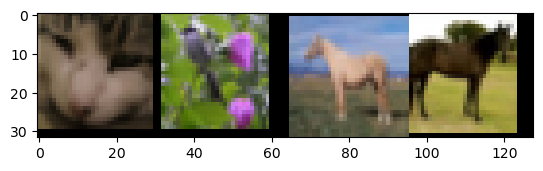

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Class labels:  cat   bird  horse horse


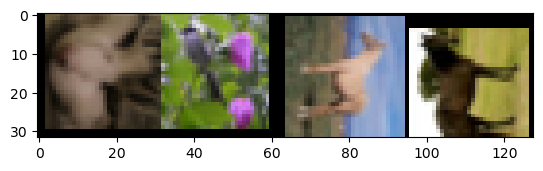

Rotation labels:  270   0     270   90   


In [3]:
import matplotlib.pyplot as plt

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

rot_classes = ('0', '90', '180', '270')


def imshow(img):
    # unnormalize
    img = transforms.Normalize((0, 0, 0), (1/0.2023, 1/0.1994, 1/0.2010))(img)
    img = transforms.Normalize((-0.4914, -0.4822, -0.4465), (1, 1, 1))(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


dataiter = iter(trainloader)
images, rot_images, rot_labels, labels = next(dataiter)

# print images and rotated images
img_grid = imshow(torchvision.utils.make_grid(images[:4], padding=0))
print('Class labels: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))
img_grid = imshow(torchvision.utils.make_grid(rot_images[:4], padding=0))
print('Rotation labels: ', ' '.join(f'{rot_classes[rot_labels[j]]:5s}' for j in range(4)))

# Evaluation code

In [3]:
import time

def run_test(net, testloader, criterion, task):
    correct = 0
    total = 0
    avg_test_loss = 0.0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for images, images_rotated, labels, cls_labels in testloader:
            if task == 'rotation':
              images, labels = images_rotated.to(device), labels.to(device)
            elif task == 'classification':
              images, labels = images.to(device), cls_labels.to(device)
            #######################################################################
            # TODO: Calculate outputs by running images through the network       #
            # The class with the highest energy is what we choose as prediction   #
            #######################################################################
            outputs = net(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            #######################################################################
            #                           End of your code                          #
            #######################################################################
            avg_test_loss += criterion(outputs, labels)  / len(testloader)
    print('TESTING:')
    print(f'Accuracy of the network on the 10000 test images: {100 * correct / total:.2f} %')
    print(f'Average loss on the 10000 test images: {avg_test_loss:.3f}')
    return 100 * correct / total

In [4]:
def adjust_learning_rate(optimizer, epoch, init_lr, decay_epochs=30):
    """Sets the learning rate to the initial LR decayed by 10 every 30 epochs"""
    lr = init_lr * (0.1 ** (epoch // decay_epochs))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

# Train a ResNet18 on the rotation task (9 points)

In this section, we will train a ResNet18 model **from scratch** on the rotation task. The input is a rotated image and the model predicts the rotation label. See the Data Setup section for details.

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

### Notice: You should not use pretrained weights from ImageNet.

In [7]:
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet18

net = resnet18(weights = None, num_classes=4) # Do not modify this line.
net = net.to(device)
print(net) # print your model and check the num_classes is correct

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [8]:
import torch.nn as nn
import torch.optim as optim
################################################################################
# TODO: Define loss and optmizer functions                                     #
# Try any loss or optimizer function and learning rate to get better result    #
# hint: torch.nn and torch.optim                                               #
################################################################################
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(net.parameters(), lr=0.001, weight_decay=0.01)
################################################################################
#                               End of your code                               #
################################################################################
criterion = criterion.to(device)

In [9]:
# Both the self-supervised rotation task and supervised CIFAR10 classification are
# trained with the CrossEntropyLoss, so we can use the training loop code.

def train(net, criterion, optimizer, num_epochs, decay_epochs, init_lr, task):
    test_acc = 0
    for epoch in range(num_epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        running_correct = 0.0
        running_total = 0.0
        start_time = time.time()

        net.train()

        for i, (imgs, imgs_rotated, rotation_label, cls_label) in enumerate(trainloader, 0):
            adjust_learning_rate(optimizer, epoch, init_lr, decay_epochs)
            ######################################################################################################
            # TODO: Set the data to the correct device; Different task will use different inputs and labels      #  
            # TODO: Zero the parameter gradients                                                                 #
            # TODO: forward + backward + optimize                                                                #
            # TODO: Get predicted results                                                                        #
            ######################################################################################################
            if task == 'rotation':
                images, labels = imgs_rotated.to(device), rotation_label.to(device)
            elif task == 'classification':
                images, labels = imgs.to(device), cls_label.to(device)

            optimizer.zero_grad()

            outputs = net(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs, 1)

            ######################################################################################################
            #                               End of your code                                                     #
            ######################################################################################################                                            


            # print statistics
            print_freq = 100
            running_loss += loss.item()

            # calc acc
            running_total += labels.size(0)
            running_correct += (predicted == labels).sum().item()

            if i % print_freq == (print_freq - 1):    # print every 2000 mini-batches
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / print_freq:.3f} acc: {100*running_correct / running_total:.2f} time: {time.time() - start_time:.2f}')
                running_loss, running_correct, running_total = 0.0, 0.0, 0.0
                start_time = time.time()
        ######################################################################################################
        # TODO: Run the run_test() function after each epoch; Set the model to the evaluation mode.          #
        ######################################################################################################
        net.eval()
        test_acc = run_test(net, testloader, criterion,task)
        ######################################################################################################
        #                               End of your code                                                     #
        ######################################################################################################  

    print('Finished Training')
    return test_acc

In [10]:
train(net, criterion, optimizer, num_epochs=45, decay_epochs=15, init_lr=0.01, task='rotation')
################################
#     TODO: Save the model     #  
################################
torch.save(net.state_dict(), 'rotation_model.pt')
################################
#      End of your code        #  
################################

/home/vllab/anaconda3/lib/python3.11/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1695392026823/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


[1,   100] loss: 1.649 acc: 29.00 time: 4.14
[1,   200] loss: 1.301 acc: 41.64 time: 2.77
[1,   300] loss: 1.194 acc: 46.05 time: 2.78
TESTING:
Accuracy of the network on the 10000 test images: 50.63 %
Average loss on the 10000 test images: 1.313
[2,   100] loss: 1.118 acc: 50.91 time: 2.77
[2,   200] loss: 1.111 acc: 51.48 time: 2.60
[2,   300] loss: 1.094 acc: 52.77 time: 2.61
TESTING:
Accuracy of the network on the 10000 test images: 55.89 %
Average loss on the 10000 test images: 1.030
[3,   100] loss: 1.064 acc: 54.26 time: 2.73
[3,   200] loss: 1.042 acc: 55.39 time: 2.61
[3,   300] loss: 1.035 acc: 55.77 time: 2.67
TESTING:
Accuracy of the network on the 10000 test images: 56.44 %
Average loss on the 10000 test images: 1.043
[4,   100] loss: 1.004 acc: 57.41 time: 2.88
[4,   200] loss: 0.986 acc: 58.11 time: 2.74
[4,   300] loss: 0.986 acc: 58.12 time: 2.80
TESTING:
Accuracy of the network on the 10000 test images: 59.86 %
Average loss on the 10000 test images: 0.950
[5,   100] l

## Fine-tuning on the pre-trained model (9 points)

In this section, we will load the ResNet18 model pre-trained on the rotation task and fine-tune on the classification task. We will freeze all previous layers except for the 'layer4' block and 'fc' layer.

**Then we will use the trained model from rotation task as the pretrained weights. Notice, you should not use the pretrained weights from ImageNet.**

In [11]:
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet18

#####################################################
#     TODO: Load the pre-trained ResNet18 model     #  
#####################################################
ckpt = torch.load('rotation_model.pt')
net = resnet18(weights = None, num_classes = 4)
net.load_state_dict(ckpt)
num_classes=10
net.fc = torch.nn.Linear(net.fc.in_features, num_classes)
net = net.to(device)
print(net) # print your model and check the num_classes is correct
####################################################
#                End of your code                  #   
####################################################

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [12]:
#################################################################################################
#   TODO: Freeze all previous layers; only keep the 'layer4' block and 'fc' layer trainable     #
#################################################################################################
for name, param in net.named_parameters():
    if 'layer4' not in name and 'fc' not in name:
        param.requires_grad = False
#################################################################################################
#                                          End of your code                                     #
#################################################################################################

In [13]:
# Print all the trainable parameters
params_to_update = net.parameters()
print("Params to learn:")
params_to_update = []
for name,param in net.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Params to learn:
	 layer4.0.conv1.weight
	 layer4.0.bn1.weight
	 layer4.0.bn1.bias
	 layer4.0.conv2.weight
	 layer4.0.bn2.weight
	 layer4.0.bn2.bias
	 layer4.0.downsample.0.weight
	 layer4.0.downsample.1.weight
	 layer4.0.downsample.1.bias
	 layer4.1.conv1.weight
	 layer4.1.bn1.weight
	 layer4.1.bn1.bias
	 layer4.1.conv2.weight
	 layer4.1.bn2.weight
	 layer4.1.bn2.bias
	 fc.weight
	 fc.bias


In [14]:
# TODO: Define criterion and optimizer
# Note that your optimizer only needs to update the parameters that are trainable.
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(filter(lambda x: x.requires_grad, net.parameters()), lr= 3e-4)

In [15]:
train(net, criterion, optimizer, num_epochs=20, decay_epochs=10, init_lr=0.01, task='classification')


[1,   100] loss: 1.719 acc: 35.77 time: 2.88
[1,   200] loss: 1.448 acc: 46.83 time: 2.62
[1,   300] loss: 1.394 acc: 49.17 time: 2.63
TESTING:
Accuracy of the network on the 10000 test images: 53.14 %
Average loss on the 10000 test images: 1.302
[2,   100] loss: 1.345 acc: 50.95 time: 2.78
[2,   200] loss: 1.325 acc: 51.64 time: 2.68
[2,   300] loss: 1.308 acc: 52.34 time: 2.59
TESTING:
Accuracy of the network on the 10000 test images: 55.44 %
Average loss on the 10000 test images: 1.238
[3,   100] loss: 1.299 acc: 52.71 time: 2.73
[3,   200] loss: 1.268 acc: 54.27 time: 2.61
[3,   300] loss: 1.279 acc: 54.37 time: 2.60
TESTING:
Accuracy of the network on the 10000 test images: 54.42 %
Average loss on the 10000 test images: 1.278
[4,   100] loss: 1.268 acc: 53.99 time: 2.74
[4,   200] loss: 1.255 acc: 54.99 time: 2.63
[4,   300] loss: 1.260 acc: 54.08 time: 2.56
TESTING:
Accuracy of the network on the 10000 test images: 56.69 %
Average loss on the 10000 test images: 1.199
[5,   100] l

62.09

## Fine-tuning on the randomly initialized model (9 points)
In this section, we will randomly initialize a ResNet18 model and fine-tune on the classification task. We will freeze all previous layers except for the 'layer4' block and 'fc' layer.

In [16]:
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet18
#################################################
# TODO: Randomly initialize a ResNet18 model    #
#################################################
net = resnet18(weights=None, num_classes= 10)  ### not sure
net = net.to(device)
print(net) # print your model and check the num_classes is correct
#################################################
#              End of your code                 #
#################################################

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [17]:
#################################################################################################
# TODO: Freeze all previous layers; only keep the 'layer4' block and 'fc' layer trainable       #
# To do this, you should set requires_grad=False for the frozen layers.                         #
#################################################################################################
for name, param in net.named_parameters():
    if 'layer4' not in name and 'fc' not in name:
        param.requires_grad = False
#################################################################################################
#                                          End of your code                                     #
#################################################################################################


In [18]:
# Print all the trainable parameters
params_to_update = net.parameters()
print("Params to learn:")
params_to_update = []
for name,param in net.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Params to learn:
	 layer4.0.conv1.weight
	 layer4.0.bn1.weight
	 layer4.0.bn1.bias
	 layer4.0.conv2.weight
	 layer4.0.bn2.weight
	 layer4.0.bn2.bias
	 layer4.0.downsample.0.weight
	 layer4.0.downsample.1.weight
	 layer4.0.downsample.1.bias
	 layer4.1.conv1.weight
	 layer4.1.bn1.weight
	 layer4.1.bn1.bias
	 layer4.1.conv2.weight
	 layer4.1.bn2.weight
	 layer4.1.bn2.bias
	 fc.weight
	 fc.bias


In [19]:
# TODO: Define criterion and optimizer
# Note that your optimizer only needs to update the parameters that are trainable.
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(filter(lambda x: x.requires_grad, net.parameters()), lr=3e-4)

In [20]:
train(net, criterion, optimizer, num_epochs=20, decay_epochs=10, init_lr=0.01, task='classification')

[1,   100] loss: 2.220 acc: 25.75 time: 2.82
[1,   200] loss: 1.931 acc: 31.19 time: 2.69
[1,   300] loss: 1.854 acc: 32.55 time: 2.81
TESTING:
Accuracy of the network on the 10000 test images: 36.04 %
Average loss on the 10000 test images: 1.774
[2,   100] loss: 1.798 acc: 35.19 time: 2.84
[2,   200] loss: 1.779 acc: 35.55 time: 2.63
[2,   300] loss: 1.775 acc: 35.39 time: 2.59
TESTING:
Accuracy of the network on the 10000 test images: 39.19 %
Average loss on the 10000 test images: 1.676
[3,   100] loss: 1.757 acc: 36.02 time: 2.75
[3,   200] loss: 1.742 acc: 37.20 time: 2.59
[3,   300] loss: 1.735 acc: 36.70 time: 2.60
TESTING:
Accuracy of the network on the 10000 test images: 40.46 %
Average loss on the 10000 test images: 1.652
[4,   100] loss: 1.716 acc: 37.57 time: 2.75
[4,   200] loss: 1.718 acc: 38.16 time: 2.67
[4,   300] loss: 1.709 acc: 38.20 time: 2.65
TESTING:
Accuracy of the network on the 10000 test images: 41.21 %
Average loss on the 10000 test images: 1.633
[5,   100] l

45.31

## Supervised training on the pre-trained model (9 points)
In this section, we will load the ResNet18 model pre-trained on the rotation task and re-train the whole model on the classification task.

**Then we will use the trained model from rotation task as the pretrained weights. Notice, you should not use the pretrained weights from ImageNet.**

In [21]:
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet18

#####################################################
#     TODO: Load the pre-trained ResNet18 model     #  
#####################################################
ckpt = torch.load('rotation_model.pt')
net = resnet18(weights = None, num_classes = 4)
net.load_state_dict(ckpt)
num_classes=10
net.fc = torch.nn.Linear(net.fc.in_features, num_classes)
net = net.to(device)
print(net) # print your model and check the num_classes is correct
#####################################################
#                End of your code                   #   
#####################################################

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [22]:
# TODO: Define criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(net.parameters(),lr=3e-4)

In [23]:
train(net, criterion, optimizer, num_epochs=20, decay_epochs=10, init_lr=0.01, task='classification')

[1,   100] loss: 1.482 acc: 45.45 time: 2.77
[1,   200] loss: 1.170 acc: 58.62 time: 2.65
[1,   300] loss: 1.073 acc: 62.38 time: 2.67
TESTING:
Accuracy of the network on the 10000 test images: 64.69 %
Average loss on the 10000 test images: 1.020
[2,   100] loss: 0.968 acc: 65.83 time: 2.71
[2,   200] loss: 0.915 acc: 67.48 time: 2.69
[2,   300] loss: 0.895 acc: 68.64 time: 2.82
TESTING:
Accuracy of the network on the 10000 test images: 67.42 %
Average loss on the 10000 test images: 0.958
[3,   100] loss: 0.839 acc: 70.97 time: 2.85
[3,   200] loss: 0.833 acc: 71.14 time: 2.79
[3,   300] loss: 0.830 acc: 71.56 time: 2.82
TESTING:
Accuracy of the network on the 10000 test images: 69.20 %
Average loss on the 10000 test images: 0.918
[4,   100] loss: 0.777 acc: 72.96 time: 2.76
[4,   200] loss: 0.766 acc: 73.50 time: 2.65
[4,   300] loss: 0.747 acc: 74.21 time: 2.59
TESTING:
Accuracy of the network on the 10000 test images: 74.80 %
Average loss on the 10000 test images: 0.730
[5,   100] l

84.11

## Supervised training on the randomly initialized model (9 points)
In this section, we will randomly initialize a ResNet18 model and re-train the whole model on the classification task.

In [24]:
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet18

#################################################
# TODO: Randomly initialize a ResNet18 model    #
#################################################
net = resnet18(weights= None, num_classes=10)
net = net.to(device)
print(net) # print your model and check the num_classes is correct
#################################################
#              End of your code                 #
#################################################

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [25]:
# TODO: Define criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(net.parameters(),lr=3e-4)

In [26]:
train(net, criterion, optimizer, num_epochs=20, decay_epochs=10, init_lr=0.01, task='classification')

[1,   100] loss: 2.257 acc: 22.14 time: 2.80
[1,   200] loss: 1.836 acc: 31.90 time: 2.66
[1,   300] loss: 1.722 acc: 36.92 time: 2.68
TESTING:
Accuracy of the network on the 10000 test images: 40.66 %
Average loss on the 10000 test images: 1.578
[2,   100] loss: 1.561 acc: 42.39 time: 2.73
[2,   200] loss: 1.469 acc: 45.92 time: 2.81
[2,   300] loss: 1.400 acc: 48.48 time: 2.81
TESTING:
Accuracy of the network on the 10000 test images: 53.12 %
Average loss on the 10000 test images: 1.298
[3,   100] loss: 1.297 acc: 52.70 time: 2.80
[3,   200] loss: 1.224 acc: 56.20 time: 2.64
[3,   300] loss: 1.181 acc: 57.67 time: 2.62
TESTING:
Accuracy of the network on the 10000 test images: 58.44 %
Average loss on the 10000 test images: 1.165
[4,   100] loss: 1.119 acc: 59.87 time: 2.75
[4,   200] loss: 1.095 acc: 60.70 time: 2.65
[4,   300] loss: 1.064 acc: 62.37 time: 2.69
TESTING:
Accuracy of the network on the 10000 test images: 64.70 %
Average loss on the 10000 test images: 0.996
[5,   100] l

82.33

# Write report (37 points)

本次作業主要有3個tasks需要大家完成，在A4.pdf中有希望大家達成的baseline **(不能低於baseline最多2%，沒有達到不會給全部分數)**，report的撰寫請大家根據以下要求完成，就請大家將嘗試的結果寫在report裡，祝大家順利！

1. (13 points) Train a ResNet18 on the Rotation task and report the test performance. Discuss why such a task helps in learning features that are generalizable to other visual tasks.

2. (12 points) Initializing from the Rotation model or from random weights, fine-tune only the weights of the final block of convolutional layers and linear layer on the supervised CIFAR10 classification task. Report the test results and compare the performance of these two models. Provide your observations and insights. You can also discuss how the performance of pre-trained models affects downstream tasks, the performance of fine-tuning different numbers of layers, and so on.

3. (12 points) Initializing from the Rotation model or from random weights, train the full network on the supervised CIFAR10 classification task. Report the test results and compare the performance of these two models. Provide your observations and insights.

# Extra Credit (13 points)

上面基本的code跟report最高可以拿到87分，這個加分部分並沒有要求同學們一定要做，若同學們想要獲得更高的分數可以根據以下的加分要求來獲得加分。

- In Figure 5(b) from the Gidaris et al. paper, the authors show a plot of CIFAR10 classification performance vs. number of training examples per category for a supervised CIFAR10 model vs. a RotNet model with the final layers fine-tuned on CIFAR10. The plot shows that pre-training on the Rotation task can be advantageous when only a small amount of labeled data is available. Using your RotNet fine-tuning code and supervised CIFAR10 training code from the main assignment, try to create a similar plot by performing supervised fine-tuning/training on only a subset of CIFAR10.
- Use a more advanced model than ResNet18 to try to get higher accuracy on the rotation prediction task, as well as for transfer to supervised CIFAR10 classification.
  
- If you have a good amount of compute at your disposal, try to train a rotation prediction model on the larger ImageNette dataset (still smaller than ImageNet, though).


- plot supervised v.s. fine-tuning when trained on only a subset of CIFAR10

TESTING:
Accuracy of the network on the 10000 test images: 13.42 %
Average loss on the 10000 test images: 2.221
TESTING:
Accuracy of the network on the 10000 test images: 13.94 %
Average loss on the 10000 test images: 2.241
TESTING:
Accuracy of the network on the 10000 test images: 15.03 %
Average loss on the 10000 test images: 2.213
TESTING:
Accuracy of the network on the 10000 test images: 19.77 %
Average loss on the 10000 test images: 2.158
TESTING:
Accuracy of the network on the 10000 test images: 22.97 %
Average loss on the 10000 test images: 2.107
TESTING:
Accuracy of the network on the 10000 test images: 25.64 %
Average loss on the 10000 test images: 2.045
TESTING:
Accuracy of the network on the 10000 test images: 27.61 %
Average loss on the 10000 test images: 1.993
TESTING:
Accuracy of the network on the 10000 test images: 27.41 %
Average loss on the 10000 test images: 1.980
TESTING:
Accuracy of the network on the 10000 test images: 27.72 %
Average loss on the 10000 test images

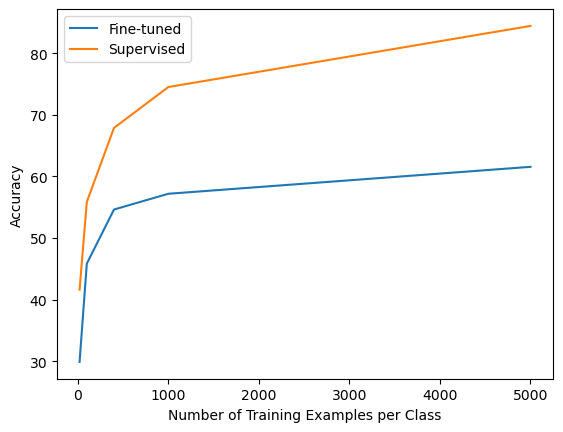

In [27]:
import matplotlib.pyplot as plt


def get_data_subset(dataset, num_examples_per_class): 
    # Obtain all possible classes from the dataset
    classes = np.unique(np.array(dataset.targets))
    
    # Placeholder for indices to extract for the subset
    indices = []
    
    # Loop over each class and randomly select num_examples_per_class indices
    for cls in classes:
        cls_indices = np.where(np.array(dataset.targets) == cls)[0]
        cls_subset_indices = np.random.choice(cls_indices, num_examples_per_class, replace=False)
        indices.extend(cls_subset_indices)
    
    # Use Subset to create a new dataset from the selected indices
    subset_dataset = torch.utils.data.Subset(dataset, indices)
    
    return subset_dataset



# Number of samples per class for subsetting the CIFAR10 dataset
samples_per_class = [20, 100, 400, 1000, 5000]

fine_tune_accuracies = []
supervised_accuracies = []

for spc in samples_per_class:
    # Get a subset of CIFAR10 data
    trainset_subset = get_data_subset(trainset, spc)
    trainloader = torch.utils.data.DataLoader(trainset_subset, batch_size=batch_size,shuffle=True, num_workers=2)

    ckpt = torch.load('rotation_model.pt')
    net = resnet18(weights = None, num_classes = 4)
    net.load_state_dict(ckpt)
    num_classes=10
    net.fc = torch.nn.Linear(net.fc.in_features, num_classes)
    net = net.to(device)

    for name, param in net.named_parameters():
        if 'layer4' not in name and 'fc' not in name:
            param.requires_grad = False
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(filter(lambda x: x.requires_grad, net.parameters()), lr=3e-4)

    test_acc = train(net, criterion, optimizer, num_epochs=20, decay_epochs=10, init_lr=0.01, task='classification')

    fine_tune_accuracies.append(test_acc)

    

    
    ckpt = torch.load('rotation_model.pt')
    net2 = resnet18(weights = None, num_classes = 4)
    net2.load_state_dict(ckpt)
    num_classes=10
    net2.fc = torch.nn.Linear(net2.fc.in_features, num_classes)
    net2 = net2.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(net2.parameters(),lr=3e-4)

    test2_acc = train(net2, criterion, optimizer, num_epochs=20, decay_epochs=10, init_lr=0.01, task='classification')
    supervised_accuracies.append(test2_acc)
    
    
# Plot the results
plt.plot(samples_per_class, fine_tune_accuracies, label='Fine-tuned')
plt.plot(samples_per_class, supervised_accuracies, label='Supervised')
plt.xlabel('Number of Training Examples per Class')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


- More Advanced model than ResNet18

In [28]:
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import densenet121

ad_model = densenet121(weights = None, num_classes=4) 
ad_model = ad_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(ad_model.parameters(), lr=0.001, weight_decay=0.01)
criterion = criterion.to(device)


train(ad_model, criterion, optimizer, num_epochs=45, decay_epochs=15, init_lr=0.01, task='rotation')
torch.save(ad_model.state_dict(), 'ad_rotation_model.pt')



print("="*20,"supervised CIFAR10","="*20)


ckpt = torch.load('ad_rotation_model.pt')
ad_model = densenet121(weights = None, num_classes = 4)
ad_model.load_state_dict(ckpt)
num_classes=10
ad_model.classifier = nn.Linear(ad_model.classifier.in_features, num_classes)
ad_model = ad_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(ad_model.parameters(),lr=3e-4)

train(ad_model, criterion, optimizer, num_epochs=20, decay_epochs=10, init_lr=0.01, task='classification')

[1,   100] loss: 1.632 acc: 28.70 time: 6.01
[1,   200] loss: 1.328 acc: 39.38 time: 5.19
[1,   300] loss: 1.272 acc: 43.46 time: 5.67
TESTING:
Accuracy of the network on the 10000 test images: 47.72 %
Average loss on the 10000 test images: 1.177
[2,   100] loss: 1.191 acc: 45.80 time: 5.86
[2,   200] loss: 1.189 acc: 45.72 time: 5.29
[2,   300] loss: 1.160 acc: 47.49 time: 5.34
TESTING:
Accuracy of the network on the 10000 test images: 51.26 %
Average loss on the 10000 test images: 1.102
[3,   100] loss: 1.139 acc: 49.41 time: 5.97
[3,   200] loss: 1.097 acc: 52.77 time: 5.84
[3,   300] loss: 1.082 acc: 53.91 time: 5.84
TESTING:
Accuracy of the network on the 10000 test images: 57.12 %
Average loss on the 10000 test images: 1.030
[4,   100] loss: 1.035 acc: 55.84 time: 5.63
[4,   200] loss: 1.018 acc: 56.63 time: 5.29
[4,   300] loss: 1.016 acc: 56.94 time: 5.32
TESTING:
Accuracy of the network on the 10000 test images: 58.20 %
Average loss on the 10000 test images: 0.980
[5,   100] l

84.85

- Train rotation prediction model on imagenette

In [29]:
import tarfile

# Path to the downloaded .tgz file
tgz_path = "imagenette2-160.tgz"
# Directory where you want to extract the dataset
extract_path = "./imagenette2"

# Extract the .tgz file
with tarfile.open(tgz_path, "r:gz") as tar:
    tar.extractall(path=extract_path)

print(f"Extracted to {extract_path}")


Extracted to ./imagenette2


In [22]:
import os
for res in os.walk('./imagenette2/imagenette2/train/'):
    print(res)

('./imagenette2/imagenette2/train/', ['n02979186', 'n01440764', 'n03000684', 'n03888257', 'n03445777', 'n03394916', 'n02102040', 'n03028079', 'n03417042', 'n03425413'], [])
('./imagenette2/imagenette2/train/n02979186', [], ['n02979186_20733.JPEG', 'n02979186_1897.JPEG', 'n02979186_5043.JPEG', 'n02979186_2854.JPEG', 'ILSVRC2012_val_00012468.JPEG', 'n02979186_18456.JPEG', 'n02979186_10874.JPEG', 'n02979186_11396.JPEG', 'n02979186_8254.JPEG', 'n02979186_1198.JPEG', 'n02979186_15085.JPEG', 'n02979186_21218.JPEG', 'n02979186_5695.JPEG', 'n02979186_14047.JPEG', 'n02979186_4273.JPEG', 'n02979186_20619.JPEG', 'n02979186_10056.JPEG', 'n02979186_5638.JPEG', 'n02979186_11875.JPEG', 'n02979186_11675.JPEG', 'n02979186_23516.JPEG', 'n02979186_9717.JPEG', 'n02979186_758.JPEG', 'n02979186_20577.JPEG', 'n02979186_3543.JPEG', 'n02979186_437.JPEG', 'n02979186_12553.JPEG', 'n02979186_10289.JPEG', 'n02979186_11636.JPEG', 'n02979186_6616.JPEG', 'n02979186_13588.JPEG', 'n02979186_22969.JPEG', 'n02979186_1111

In [66]:
imagenette_transform_train = transforms.Compose([
    transforms.Resize((320, 320)), # Resize the image 
    transforms.RandomCrop(288),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

imagenette_transform_val = transforms.Compose([
    transforms.Resize((288, 288)), # Resize the image 
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),

])

In [67]:
import os
from PIL import Image
from torchvision.datasets import VisionDataset
import torch

class ImageNetteRotation(VisionDataset):

    def __init__(self, root,train ,transform=None):
        super().__init__(root, transform=transform)

        root = root+train
        # folder structure of 'imagenette/imagenette2-160/train' and 'imagenette/imagenette2-160/val'
        self.images = []
        self.labels = []
        
        for dirname, _, filenames in os.walk(root):
            for filename in filenames:
                if filename.endswith('.JPEG'):
                    self.images.append(os.path.join(dirname, filename))
                    # In ImageNette, class labels are encoded in the directory names
                    self.labels.append(dirname.split('/')[-1])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        img_path = self.images[index]
        img = Image.open(img_path).convert('RGB')

        # Apply the transformation if specified
        if self.transform:
            img = self.transform(img)

        # Randomly select image rotation
        rotation_label = random.choice([0, 1, 2, 3])
        img_rotated = rotate_img(img, rotation_label)
        
        # Convert the class label to a numerical format
        cls_label = self._class_to_index(self.labels[index])

        rotation_label = torch.tensor(rotation_label).long()
        return img, img_rotated, rotation_label, torch.tensor(cls_label).long()

    def _class_to_index(self, class_name):
        # This could be a dictionary mapping from class names to numbers
        class_to_idx = {'n01440764': 0, 'n02102040': 1, 'n02979186': 2, 'n03000684': 3, 'n03028079': 4, 'n03394916': 5, 'n03417042': 6, 'n03425413': 7, 'n03445777': 8, 'n03888257': 9}  # Fill in with actual mappings
        return class_to_idx[class_name]

# Example usage
root_dir = './imagenette2/imagenette2-160/'  # Or './imagenette/val' for validation set

batch_size = 64

imagenette_train_rotation_dataset = ImageNetteRotation(root=root_dir,train = 'train' ,transform=imagenette_transform_train)
imagenette_trainloader = torch.utils.data.DataLoader(imagenette_train_rotation_dataset,batch_size=batch_size,shuffle=True,num_workers=2)


imagenette_val_rotation_dataset = ImageNetteRotation(root=root_dir,train = 'val' ,transform=imagenette_transform_val)
imagenette_valloader = torch.utils.data.DataLoader(imagenette_val_rotation_dataset,batch_size=batch_size,shuffle=False,num_workers=2)


In [68]:
print(len(imagenette_train_rotation_dataset))
print(len(imagenette_val_rotation_dataset))
print(imagenette_train_rotation_dataset.labels[0])
print(imagenette_train_rotation_dataset._class_to_index(imagenette_train_rotation_dataset.labels[0]))


9469
3925
n02979186
2


In [69]:
import time

def imagenette_run_test(net, imagenette_valloader, criterion, task):
    correct = 0
    total = 0
    avg_test_loss = 0.0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for images, images_rotated, labels, cls_labels in imagenette_valloader:
            torch.cuda.empty_cache()

            if task == 'rotation':
              images, labels = images_rotated.to(device), labels.to(device)
            elif task == 'classification':
              images, labels = images.to(device), cls_labels.to(device)
            #######################################################################
            # TODO: Calculate outputs by running images through the network       #
            # The class with the highest energy is what we choose as prediction   #
            #######################################################################
            outputs = net(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            #######################################################################
            #                           End of your code                          #
            #######################################################################
            avg_test_loss += criterion(outputs, labels)  / len(imagenette_valloader)
    print('evaluating on imagenette validation set:')
    print('Accuracy of the network on the 3925 validation images:', f'{100 * correct / total:.2f} %')
    print('Average loss on the 3925 validation images:', f'{avg_test_loss:.3f}')
    return 100 * correct / total



def imagenette_train(net, criterion, optimizer, num_epochs, decay_epochs, init_lr, task):
    test_acc = 0
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        torch.cuda.empty_cache()

        running_loss = 0.0
        running_correct = 0.0
        running_total = 0.0
        start_time = time.time()

        net.train()

        for i, (imgs, imgs_rotated, rotation_label, cls_label) in enumerate(imagenette_trainloader, 0):
            torch.cuda.empty_cache()

            adjust_learning_rate(optimizer, epoch, init_lr, decay_epochs)
            ######################################################################################################
            # TODO: Set the data to the correct device; Different task will use different inputs and labels      #  
            # TODO: Zero the parameter gradients                                                                 #
            # TODO: forward + backward + optimize                                                                #
            # TODO: Get predicted results                                                                        #
            ######################################################################################################
            if task == 'rotation':
                images, labels = imgs_rotated.to(device), rotation_label.to(device)
            elif task == 'classification':
                images, labels = imgs.to(device), cls_label.to(device)

            optimizer.zero_grad()

            outputs = net(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs, 1)

            ######################################################################################################
            #                               End of your code                                                     #
            ######################################################################################################                                            


            # print statistics
            print_freq = 35
            running_loss += loss.item()

            # calc acc
            running_total += labels.size(0)
            running_correct += (predicted == labels).sum().item()

            if i % print_freq == (print_freq - 1):    # print every 2000 mini-batches
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / print_freq:.3f} acc: {100*running_correct / running_total:.2f} time: {time.time() - start_time:.2f}')
                running_loss, running_correct, running_total = 0.0, 0.0, 0.0
                start_time = time.time()
        ######################################################################################################
        # TODO: Run the run_test() function after each epoch; Set the model to the evaluation mode.          #
        ######################################################################################################
        net.eval()
        test_acc = imagenette_run_test(net, imagenette_valloader, criterion,task)
        ######################################################################################################
        #                               End of your code                                                     #
        ######################################################################################################  

    print('Finished Training')
    return test_acc

In [70]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.models import resnet18


net = resnet18(weights = None, num_classes=4) # Do not modify this line.
net = net.to(device)


criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(net.parameters(), lr=3e-4, weight_decay=0.01)
criterion = criterion.to(device)

imagenette_train(net, criterion, optimizer, num_epochs=45, decay_epochs=15, init_lr=0.01, task='rotation')

torch.save(net.state_dict(),'rotation_trained_on_imagenette_model.pt')


### supervised training on the pre-trained model
ckpt = torch.load('rotation_trained_on_imagenette_model.pt')
net = resnet18(weights = None, num_classes = 4)
net.load_state_dict(ckpt)
num_classes=10
net.fc = torch.nn.Linear(net.fc.in_features, num_classes)
net = net.to(device)


criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(net.parameters(),lr=3e-4)

train(net, criterion, optimizer, num_epochs=20, decay_epochs=10, init_lr=0.01, task='classification')

[1,    35] loss: 1.968 acc: 23.71 time: 6.98
[1,    70] loss: 1.433 acc: 24.96 time: 6.65
[1,   105] loss: 1.416 acc: 23.48 time: 6.67
[1,   140] loss: 1.420 acc: 25.00 time: 6.68
evaluating on imagenette validation set:
Accuracy of the network on the 3925 validation images: 24.59 %
Average loss on the 3925 validation images: 1.400
[2,    35] loss: 1.407 acc: 27.10 time: 6.99
[2,    70] loss: 1.384 acc: 28.97 time: 6.69
[2,   105] loss: 1.360 acc: 32.19 time: 6.69
[2,   140] loss: 1.298 acc: 38.57 time: 6.71
evaluating on imagenette validation set:
Accuracy of the network on the 3925 validation images: 40.89 %
Average loss on the 3925 validation images: 1.279
[3,    35] loss: 1.262 acc: 41.74 time: 7.01
[3,    70] loss: 1.253 acc: 42.32 time: 6.68
[3,   105] loss: 1.228 acc: 43.93 time: 6.68
[3,   140] loss: 1.225 acc: 43.84 time: 6.70
evaluating on imagenette validation set:
Accuracy of the network on the 3925 validation images: 44.99 %
Average loss on the 3925 validation images: 1.19

81.97